# IMPORTS

In [51]:
# adding necessary imports
import csv
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
import heapq
import torch.nn.functional as F
from tqdm import tqdm
from torch.nn.utils import clip_grad_norm_
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn as sns
import random
import wandb
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Setting devide to gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# login to wandb
!wandb login 3c81526a5ec348850a4c9d0f852f6631959307ed

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# PREPROCESSING

In [4]:
def loadData(params):
    """
    This function loads and preprocesses the data for machine translation.

    Args:
        params (dict): A dictionary containing parameters for data loading.
            - 'language': The language of the dataset (e.g., 'en', 'fr').
            - 'dataset_path': The path to the directory containing the dataset.

    Returns:
        dict: A dictionary containing the preprocessed data.
    """
    language = params['language']
    dataset_path = params['dataset_path']
    # Construct file paths for training, validation, and testing data
    train_path = os.path.join(dataset_path, language, language + '_train.csv')
    val_path = os.path.join(dataset_path, language, language + '_valid.csv')
    test_path = os.path.join(dataset_path, language, language + '_test.csv')

    # Open and read data from CSV files using UTF-8 encoding for proper character handling
    train_data = csv.reader(open(train_path, encoding='utf8'))
    val_data = csv.reader(open(val_path, encoding='utf8'))
    test_data = csv.reader(open(test_path, encoding='utf8'))

    # Initialize empty lists to store source and target language sentences
    train_words, train_translations = [], []
    val_words, val_translations = [], []
    test_words, test_translations = [], []

    # Define special symbols for padding, sentence start, and sentence end
    pad, start, end = '', '^', '$'

    # Preprocess data by adding special symbols to sentence ends
    for pair in train_data:
        train_words.append(pair[0] + end)
        train_translations.append(start + pair[1] + end)
    for pair in val_data:
        val_words.append(pair[0] + end)
        val_translations.append(start + pair[1] + end)
    for pair in test_data:
        test_words.append(pair[0] + end)
        test_translations.append(start + pair[1] + end)
    
    # Convert lists to NumPy arrays for efficient processing
    train_words , train_translations = np.array(train_words), np.array(train_translations)
    val_words , val_translations = np.array(val_words), np.array(val_translations)
    test_words , test_translations = np.array(test_words), np.array(test_translations)
    
    # Create sets to store unique characters in source and target vocabulary
    input_vocab = set()
    output_vocab = set()
    
    # Iterate through words to collect all unique characters
    for w in train_words:
        for c in w:
            input_vocab.add(c)
    for w in val_words:
        for c in w:
            input_vocab.add(c)
    for w in test_words:
        for c in w:
            input_vocab.add(c)
            
    for w in train_translations:
        for c in w:
            output_vocab.add(c)
    for w in val_translations:
        for c in w:
            output_vocab.add(c)
    for w in test_translations:
        for c in w:
            output_vocab.add(c)
    
    # Remove special symbols from vocabulary sets
    input_vocab.remove(end)
    output_vocab.remove(start)
    output_vocab.remove(end)

    # Sort vocabulary sets and add special symbols as prefixes
    input_vocab, output_vocab = [pad, start, end] + list(sorted(input_vocab)), [pad, start, end] + list(sorted(output_vocab))

    # Create dictionaries to map characters to their indices and vice versa
    input_index = {char: idx for idx, char in enumerate(input_vocab)}
    output_index = {char: idx for idx, char in enumerate(output_vocab)}
    input_index_rev = {idx: char for char, idx in input_index.items()}
    output_index_rev = {idx: char for char, idx in output_index.items()}

    # Find the maximum length of sentences in source and target data
    max_enc_len = max([len(word) for word in np.hstack((train_words, test_words, val_words))])
    max_dec_len = max([len(word) for word in np.hstack((train_translations, val_translations, test_translations))])
    max_len = max(max_enc_len, max_dec_len)
      
    # returning data
    preprocessed_data = {
        'SOS' : start,
        'EOS' : end,
        'PAD' : pad,
        'train_words' : train_words,
        'train_translations' : train_translations,
        'val_words' : val_words,
        'val_translations' : val_translations,
        'test_words' : test_words,
        'test_translations' : test_translations,
        'max_enc_len' : max_enc_len,
        'max_dec_len' : max_dec_len,
        'max_len' : max_len,
        'input_index' : input_index,
        'output_index' : output_index,
        'input_index_rev' : input_index_rev,
        'output_index_rev' : output_index_rev
    }
    return preprocessed_data

In [5]:
def create_tensor(preprocessed_data):
    """
    This function creates PyTorch tensors from the preprocessed data.

    Args:
        preprocessed_data (dict): A dictionary containing the preprocessed data.

    Returns:
        dict: A dictionary containing PyTorch tensors for training, validation, and testing data.
    """

    # Define the maximum sequence length based on preprocessed data
    max_len = preprocessed_data['max_len']

    # Create empty NumPy arrays to store padded sequences for training, validation, and testing
    input_data = np.zeros((max_len, len(preprocessed_data['train_words'])), dtype='int64')
    output_data = np.zeros((max_len, len(preprocessed_data['train_words'])), dtype='int64')
    
    val_input_data = np.zeros((max_len, len(preprocessed_data['val_words'])), dtype='int64')
    val_output_data = np.zeros((max_len, len(preprocessed_data['val_words'])), dtype='int64')
    
    test_input_data = np.zeros((max_len, len(preprocessed_data['test_words'])), dtype='int64')
    test_output_data = np.zeros((max_len, len(preprocessed_data['test_words'])), dtype='int64')

    # Iterate through training data and populate tensors with character indices
    for idx, (w, t) in enumerate(zip(preprocessed_data['train_words'], preprocessed_data['train_translations'])):
        for i, char in enumerate(w):
            input_data[i, idx] = preprocessed_data['input_index'][char]
        for i, char in enumerate(t):
            output_data[i, idx] = preprocessed_data['output_index'][char]

    # Repeat the process for validation and testing data
    for idx, (w, t) in enumerate(zip(preprocessed_data['val_words'], preprocessed_data['val_translations'])):
        for i, char in enumerate(w):
            val_input_data[i, idx] = preprocessed_data['input_index'][char]
        for i, char in enumerate(t):
            val_output_data[i, idx] = preprocessed_data['output_index'][char]

    for idx, (w, t) in enumerate(zip(preprocessed_data['test_words'], preprocessed_data['test_translations'])):
        for i, char in enumerate(w):
            test_input_data[i, idx] = preprocessed_data['input_index'][char]
        for i, char in enumerate(t):
            test_output_data[i, idx] = preprocessed_data['output_index'][char]

    # Convert NumPy arrays to PyTorch tensors for efficient GPU processing (if available)
    input_data, output_data = torch.tensor(input_data, dtype=torch.int64), torch.tensor(output_data, dtype=torch.int64)
    val_input_data, val_output_data = torch.tensor(val_input_data, dtype=torch.int64), torch.tensor(val_output_data, dtype=torch.int64)
    test_input_data, test_output_data = torch.tensor(test_input_data, dtype=torch.int64), torch.tensor(test_output_data, dtype=torch.int64)

    # Create a dictionary to store all the tensors
    tensors = {
        'input_data': input_data,
        'output_data': output_data,
        'val_input_data': val_input_data,
        'val_output_data': val_output_data,
        'test_input_data': test_input_data,
        'test_output_data': test_output_data
    }

    return tensors


In [6]:
# dict = {
# 'language' : 'hin',
# # 'dataset_path' : r'C:\Users\gragh\OneDrive\Desktop\Codes\CS6910 DL\Assignment 3\DataSet\aksharantar_sampled',
# 'dataset_path' : '/kaggle/input/dl-ass3/aksharantar_sampled'
# }
# preprocessed_data = loadData(dict)
# tensors = create_tensor(preprocessed_data)

# print('Input data : ', preprocessed_data['train_words'])
# print('Output data : ', preprocessed_data['train_translations'])
# print('Number of samples : ', len(preprocessed_data['train_words']))

# print('Input data : ', preprocessed_data['val_words'])
# print('Output data : ', preprocessed_data['val_translations'])
# print('Number of val samples : ', len(preprocessed_data['val_words']))

# print('Input data : ', preprocessed_data['test_words'])
# print('Output data : ', preprocessed_data['test_translations'])
# print('Number of test samples : ', len(preprocessed_data['test_words']))

# print('Max incoder length : ', preprocessed_data['max_enc_len'])
# print('Max incoder length : ', preprocessed_data['max_enc_len'])
# print('Max length : ', preprocessed_data['max_len'])

# print('Input index length', len(preprocessed_data['input_index']))
# print('Output index length', len(preprocessed_data['output_index']))
# print('Input index', preprocessed_data['input_index'])
# print('Output index', preprocessed_data['output_index'])
# print('Input index Rev', preprocessed_data['input_index_rev'])
# print('Output index Rev', preprocessed_data['output_index_rev'])

# print('Input Data', tensors['input_data'].shape)
# print('Output Data', tensors['output_data'].shape)
# print('Input Data Val', tensors['val_input_data'].shape)
# print('Output Data Val', tensors['val_output_data'].shape)
# print('Input Data Test', tensors['test_input_data'].shape)
# print('Output Data Test', tensors['test_output_data'].shape)

# print(tensors['input_data'][:,0])
# print(tensors['output_data'][:,0])

# ATTENTION

In [7]:
class Attention(nn.Module):
  """
  This class implements an attention mechanism for a Seq2Seq model.

  The attention mechanism allows the decoder to focus on relevant parts of the encoder output
  during the decoding process, improving the model's ability to translate sequences.
  """

  def __init__(self, hidden_size):
    """
    Initializes the attention layer.

    Args:
        hidden_size (int): The size of the hidden state vectors in the model.
    """
    super(Attention, self).__init__()
    self.hidden_size = hidden_size  # Store the hidden size for calculations

  def dot_score(self, hidden_state, encoder_states):
    """
    Calculates the attention scores between the decoder hidden state and encoder outputs.

    Args:
        hidden_state (torch.Tensor): The hidden state of the decoder at a specific time step.
        encoder_states (torch.Tensor): A tensor containing the encoder outputs for all time steps.

    Returns:
        torch.Tensor: A tensor containing the attention scores for each encoder output.
    """
    # Calculate the dot product between the decoder hidden state and each encoder output vector
    return torch.sum(hidden_state * encoder_states, dim=2)  # Summation over the feature dimension

  def forward(self, hidden, encoder_outputs):
    """
    Calculates the attention weights for a given decoder hidden state and encoder outputs.

    Args:
        hidden (torch.Tensor): The hidden state of the decoder at a specific time step.
        encoder_outputs (torch.Tensor): A tensor containing the encoder outputs for all time steps.

    Returns:
        torch.Tensor: A tensor containing the attention weights for each encoder output.
    """
    # Calculate attention scores using dot product
    attn_scores = self.dot_score(hidden, encoder_outputs)

    # Transpose the scores for softmax calculation (scores for each encoder output)
    attn_scores = attn_scores.t()

    # Apply softmax to get normalized attention weights (sum to 1)
    attn_weights = F.softmax(attn_scores, dim=1)

    # Unsqueeze to add a dimension for compatibility with decoder calculations
    return attn_weights.unsqueeze(1)


# ENCODER

In [21]:
class Encoder_Attention(nn.Module):
  """
  This class implements the encoder part of a Seq2Seq model with attention.

  The encoder takes a sequence of word indices as input and processes it to
  generate an encoded representation that captures the meaning of the sequence.
  """

  def __init__(self, params, preprocessed_data):
    """
    Initializes the encoder.

    Args:
        params (dict): A dictionary containing hyperparameters for the model.
        preprocessed_data (dict): A dictionary containing the preprocessed data.
    """
    super(Encoder_Attention, self).__init__()

    # Get hyperparameters
    self.cell_type = params['cell_type']  # Type of RNN cell (RNN, LSTM, or GRU)
    self.bi_directional = params['bi_dir']  # Whether to use a bidirectional RNN
    self.embedding_size = params['embedding_size']  # Dimensionality of word embeddings
    self.hidden_size = params['hidden_size']  # Dimensionality of hidden state
    self.dropout = nn.Dropout(params['dropout'])  # Dropout layer for regularization

    # Embedding layer
    self.embedding = nn.Embedding(len(preprocessed_data['input_index']), self.embedding_size)
    # Look up an embedding vector for each word index in the input sequence

    # Choose RNN cell based on type
    if self.cell_type == 'RNN':
      self.cell = nn.RNN(self.embedding_size, self.hidden_size, params['num_layers_enc'], dropout=params['dropout'], bidirectional=self.bi_directional)
    elif self.cell_type == 'LSTM':
      self.cell = nn.LSTM(self.embedding_size, self.hidden_size, params['num_layers_enc'], dropout=params['dropout'], bidirectional=self.bi_directional)
    elif self.cell_type == 'GRU':
      self.cell = nn.GRU(self.embedding_size, self.hidden_size, params['num_layers_enc'], dropout=params['dropout'], bidirectional=self.bi_directional)
    else:
      raise ValueError("Invalid type. Choose from 'RNN', 'LSTM', or 'GRU'.")

  def forward(self, x):
      """
      Performs the forward pass through the encoder.

      Args:
          x (torch.Tensor): A tensor containing a sequence of word indices.

      Returns:
          tuple:
              - encoder_states (torch.Tensor): The encoded representation of the input sequence for all time steps.
              - hidden (torch.Tensor): The hidden state of the RNN at the last time step (if unidirectional) or a tuple of hidden states for both directions (if bidirectional).
              - cell (torch.Tensor): The cell state of the LSTM at the last time step (if LSTM is used). (Optional, only returned for LSTMs)
      """
      embedding = self.dropout(self.embedding(x))
      if self.cell_type == 'LSTM':
          encoder_states, (hidden, cell) = self.cell(embedding)
          if self.bi_directional:
              encoder_states = encoder_states[:, :, :self.hidden_size] + encoder_states[:, : ,self.hidden_size:]
          return encoder_states, hidden, cell
      else:
          encoder_states, hidden = self.cell(embedding)
          if self.bi_directional:
              encoder_states = encoder_states[:, :, :self.hidden_size] + encoder_states[:, : ,self.hidden_size:]
          return encoder_states, hidden

# DECODER

In [22]:
class Decoder_Attention(nn.Module):
  """
  This class implements the decoder part of a Seq2Seq model with attention.

  The decoder takes an embedded target sequence (one word at a time) and the
  encoder outputs as input, and generates a sequence of predicted words.
  It uses attention to focus on relevant parts of the encoder outputs
  during the decoding process.
  """

  def __init__(self, params, preprocessed_data):
    """
    Initializes the decoder.

    Args:
        params (dict): A dictionary containing hyperparameters for the model.
        preprocessed_data (dict): A dictionary containing the preprocessed data.
    """
    super(Decoder_Attention, self).__init__()

    # Get hyperparameters
    self.cell_type = params['cell_type']  # Type of RNN cell (RNN, LSTM, or GRU)
    self.num_layers = params['num_layers_dec']  # Number of decoder layers
    self.dropout = nn.Dropout(params['dropout'])  # Dropout layer for regularization
    self.embedding_size = params['embedding_size']  # Dimensionality of word embeddings

    # Embedding layer
    self.embedding = nn.Embedding(len(preprocessed_data['output_index']), params['embedding_size'])
    # Look up an embedding vector for each word index in the output sequence

    # Choose RNN cell based on type
    if self.cell_type == 'RNN':
      self.cell = nn.RNN(params['embedding_size'], params['hidden_size'], self.num_layers, dropout=params['dropout'])
    elif self.cell_type == 'LSTM':
      self.cell = nn.LSTM(params['embedding_size'], params['hidden_size'], self.num_layers, dropout=params['dropout'])
    elif self.cell_type == 'GRU':
      self.cell = nn.GRU(params['embedding_size'], params['hidden_size'], self.num_layers, dropout=params['dropout'])
    else:
      raise ValueError("Invalid type. Choose from 'RNN', 'LSTM', or 'GRU'.")

    # Layers for combining decoder output and context vector
    self.concat = nn.Linear(params['hidden_size'] * 2, params['hidden_size'])  # Linear transformation for concatenation
    self.fc = nn.Linear(params['hidden_size'], len(preprocessed_data['output_index']))  # Final linear layer for prediction

    # Attention layer
    self.attn = Attention(params['hidden_size'])  # Attention mechanism

    # Softmax for probability distribution
    self.log_softmax = nn.LogSoftmax(dim=1)

  def forward(self, x, encoder_states, hidden, cell):
    """
    Performs the forward pass through the decoder for a single time step.

    Args:
        x (torch.Tensor): A tensor containing a single word index (input to decoder at this step).
        encoder_states (torch.Tensor): The encoded representation of the input sequence from the encoder.
        hidden (torch.Tensor): The hidden state of the decoder from the previous time step.
        cell (torch.Tensor): The cell state of the LSTM decoder from the previous time step (if LSTM is used).

    Returns:
        tuple:
            - predictions (torch.Tensor): The log-softmax probabilities of the next predicted word.
            - hidden (torch.Tensor): The hidden state of the decoder for the current time step.
            - cell (torch.Tensor): The cell state of the LSTM decoder for the current time step (if LSTM is used).
            - attention_weights (torch.Tensor): The attention weights for the current time step.
    """
    # Embed the input word
    embedding = self.dropout(self.embedding(x.unsqueeze(0)))
    # Pass the embedded word through the chosen cell
    if self.cell_type == 'LSTM':
        outputs, (hidden, cell) = self.cell(embedding, (hidden, cell))
        attention_weights = self.attn(outputs, encoder_states)
        context = attention_weights.bmm(encoder_states.transpose(0, 1))
        outputs = outputs.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((outputs, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        predictions = self.log_softmax(self.fc(concat_output))
        return predictions, hidden, cell, attention_weights.squeeze(1)
    else:
        outputs, (hidden) = self.cell(embedding, hidden)
        attention_weights = self.attn(outputs, encoder_states)
        context = attention_weights.bmm(encoder_states.transpose(0, 1))
        outputs = outputs.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((outputs, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        predictions = self.log_softmax(self.fc(concat_output))
        return predictions, hidden, attention_weights.squeeze(1)

# SEQ 2 SEQ

In [23]:
class Seq2Seq_Attention(nn.Module):
  """
  This class implements a Seq2Seq model with attention mechanism.

  The model takes an encoded source sequence and a target sequence as input,
  and generates a predicted target sequence using the decoder with attention.
  """

  def __init__(self, encoder, decoder, params, preprocessed_data):
    """
    Initializes the Seq2Seq model.

    Args:
        encoder (nn.Module): The encoder module of the model.
        decoder (nn.Module): The decoder module of the model.
        params (dict): A dictionary containing hyperparameters for the model.
        preprocessed_data (dict): A dictionary containing the preprocessed data.
    """
    super(Seq2Seq_Attention, self).__init__()

    # Get hyperparameters
    self.cell_type = params['cell_type']  # Type of RNN cell (RNN, LSTM, or GRU)
    self.encoder = encoder  # Encoder module
    self.decoder = decoder  # Decoder module
    self.num_layers_dec = params['num_layers_dec']  # Number of decoder layers
    self.output_index_len = len(preprocessed_data['output_index'])  # Vocabulary size for output language
    self.tfr = params['teacher_fr']  # Teacher forcing ratio

  def forward(self, source, target):
    """
    Performs the forward pass through the entire Seq2Seq model.

    Args:
        source (torch.Tensor): A tensor containing the source sequence (encoder input).
        target (torch.Tensor): A tensor containing the target sequence (ground truth for training or prediction).

    Returns:
        torch.Tensor: A tensor containing the predicted target sequence log-softmax probabilities.
    """

    # Get batch size and target sequence length
    batch_size, target_len = source.shape[1], target.shape[0]

    # Start with the first word from the target sequence
    x = target[0, :]  # First element from each batch in the target sequence

    # Initialize empty tensor to store predictions
    outputs = torch.zeros(target_len, batch_size, self.output_index_len).to(device)

    # Get encoder outputs (encoded representation of the source sequence)
    if self.cell_type == 'LSTM':
      encoder_op, hidden, cell = self.encoder(source)
      # Truncate cell state to match decoder layer number
      cell = cell[:self.decoder.num_layers]
    else:
      encoder_op, hidden = self.encoder(source)
    # Truncate hidden state to match decoder layer number
    hidden = hidden[:self.decoder.num_layers]

    # Iterate over the target sequence length (decoding process)
    for t in range(1, target_len):
      # Use LSTM cell state or hidden state depending on cell type
      if self.cell_type == 'LSTM':
        output, hidden, cell, _ = self.decoder(x, encoder_op, hidden, cell)
      else:
        output, hidden, _ = self.decoder(x, encoder_op, hidden, None)

      # Store the predicted word probabilities and get the most likely word index
      outputs[t], best_guess = output, output.argmax(1)

      # Teacher forcing: Choose predicted word or target word based on random probability
      x = best_guess if random.random() >= self.tfr else target[t]

    # Return the tensor containing the predicted target sequence log-softmax probabilities
    return outputs


# GET OPTIMIZERS

In [24]:
def get_optim(model, params):
    """
    This function creates an optimizer object based on the specified parameters.

    Args:
        model (nn.Module): The Seq2Seq model instance.
        params (dict): A dictionary containing hyperparameters for the optimizer.
            - 'optimizer' (str): The name of the optimizer to use (e.g., 'sgd', 'adam', 'rmsprop', 'adagrad').
            - 'learning_rate' (float): The learning rate for the optimizer.

    Returns:
        optim.Optimizer: An optimizer object for training the model.
    """

    optimizer_name = params['optimizer'].lower()  # Convert optimizer name to lowercase for case-insensitive matching

    # Define the optimizer based on the specified name
    if optimizer_name == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'], momentum=0.9)
    elif optimizer_name == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], betas=(0.9, 0.999), eps=1e-8)
    elif optimizer_name == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters(), lr=params['learning_rate'], alpha=0.99, eps=1e-8)
    elif optimizer_name == 'adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=params['learning_rate'], lr_decay=0, weight_decay=0,
                                  initial_accumulator_value=0, eps=1e-10)
    else:
        raise ValueError("Invalid optimizer. Choose from 'sgd', 'adam', 'rmsprop', or 'adagrad'.")

    return optimizer


# GET TOTAL PARAMETERS

In [25]:
def get_total_parameters(model):
  """
  This function calculates the total number of trainable parameters in a PyTorch model.

  Args:
      model (nn.Module): The PyTorch model to analyze.

  Returns:
      int: The total number of trainable parameters in the model.
  """

  # Filter only trainable parameters
  total_params = sum(param.numel() for param in model.parameters() if param.requires_grad)

  return total_params


# BEAM SEARCH

In [34]:
def beam_search(model, word, preprocessed_data, params, bw = 1, lp = 0.6):
    """
    This function performs beam search to generate a translated sequence for a given source word sequence.

    Args:
        model (nn.Module): The Seq2Seq model instance.
        word (str): The source word sequence to translate.
        preprocessed_data (dict): A dictionary containing the preprocessed data.
        bw (int): Beam width for beam search.
        lp (float): Length penalty factor for beam search.
        ct (str): The type of RNN cell used in the model (LSTM or GRU).

    Returns:
        str: The predicted translated word sequence.
    """
    data = np.zeros((preprocessed_data['max_len']+1, 1), dtype=np.int32)
    for idx, char in enumerate(word):
        data[idx, 0] = preprocessed_data['input_index'][char]
    data[idx + 1, 0] = preprocessed_data['input_index'][preprocessed_data['EOS']]
    data = torch.tensor(data, dtype=torch.int32).to(device)
    with torch.no_grad():
        if params['cell_type'] == 'LSTM':
            outputs, hidden, cell = model.encoder(data)
            cell =  cell[:params['num_layers_dec']]
        else:
            outputs, hidden = model.encoder(data)
    hidden =  hidden[:params['num_layers_dec']]
    output_start = preprocessed_data['output_index'][preprocessed_data['SOS']]
    out_reshape = np.array(output_start).reshape(1,)
    hidden_par = hidden.unsqueeze(0)
    initial_sequence = torch.tensor(out_reshape).to(device)
    beam = [(0.0, initial_sequence, hidden_par)]
    for i in range(len(preprocessed_data['output_index'])):
        candidates = []
        for score, seq, hidden in beam:
            if seq[-1].item() == preprocessed_data['output_index'][preprocessed_data['EOS']]:
                candidates.append((score, seq, hidden))
                continue
            reshape_last = np.array(seq[-1].item()).reshape(1, )
            hdn = hidden.squeeze(0) 
            x = torch.tensor(reshape_last).to(device)
            if params['cell_type'] == 'LSTM':
                output, hidden, cell, _ = model.decoder(x, outputs, hdn, cell)
            else:
                output, hidden, _ = model.decoder(x, outputs, hdn, None)
            topk_probs, topk_tokens = torch.topk(F.softmax(output, dim=1), k = bw)               
            for prob, token in zip(topk_probs[0], topk_tokens[0]):
                new_seq = torch.cat((seq, token.unsqueeze(0)), dim=0)
                candidate_score = score + torch.log(prob).item() / (((len(new_seq) - 1) / 5) ** lp)
                candidates.append((candidate_score, new_seq, hidden.unsqueeze(0)))
        beam = heapq.nlargest(bw, candidates, key=lambda x: x[0])
    _, best_sequence, _ = max(beam, key=lambda x: x[0]) 
    prediction = ''.join([preprocessed_data['output_index_rev'][token.item()] for token in best_sequence[1:]])
    return prediction[:-1]


# TRAINING FUNCTION

In [35]:
def train(model, criterion, optimizer, preprocessed_data, tensors, params):
    """
    This function trains the Seq2Seq model and performs validation.

    Args:
        model (nn.Module): The Seq2Seq model instance.
        criterion (nn.Module): The loss function for training (e.g., nn.NLLLoss).
        optimizer (optim.Optimizer): The optimizer used for training (e.g., Adam).
        preprocessed_data (dict): A dictionary containing the preprocessed data.
        tensors (dict): A dictionary containing PyTorch tensors for training and validation data.
        params (dict): A dictionary containing hyperparameters for training and evaluation.

    Returns:
        tuple:
            - model (nn.Module): The trained Seq2Seq model.
            - val_accuracy (float): Overall character-level accuracy on the validation set.
            - val_accuracy_beam (float): Overall word-level accuracy on the validation set using beam search.
    """
    # splitting data ini batches
    train_data, train_result = torch.split(tensors['input_data'], params['batch_size'], dim = 1), torch.split(tensors['output_data'], params['batch_size'], dim = 1)
    val_data, val_result = torch.split(tensors['val_input_data'], params['batch_size'], dim=1), torch.split(tensors['val_output_data'], params['batch_size'], dim=1)
    
    # performing epochs
    for epoch in range(params['num_epochs']):
        total_words = 0
        correct_pred = 0
        total_loss = 0
        model.train()
        # training the model
        with tqdm(total = len(train_data), desc = 'Training') as pbar:
            for i, (x, y) in enumerate(zip(train_data, train_result)):
                target, inp_data = y.to(device), x.to(device)
                optimizer.zero_grad()
                output = model(inp_data, target)
                target = target.reshape(-1)
                output = output.reshape(-1, output.shape[2])
                # adding padding mask to ignore 0 paddding while calculating accuracy
                pad_mask = (target != preprocessed_data['output_index'][preprocessed_data['PAD']])
                target = target[pad_mask]
                output = output[pad_mask]
                
                loss = criterion(output, target)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
                optimizer.step()
                total_loss += loss.item()
                total_words += target.size(0)
                correct_pred += torch.sum(torch.argmax(output, dim=1) == target).item()
                pbar.update(1)
        train_accuracy = (correct_pred / total_words)*100
        train_loss = total_loss / len(train_data)
        # setting model in evaluation mode to validate on validation set
        model.eval()
        with torch.no_grad():
            val_total_loss = 0
            val_total_words = 0
            val_correct_pred = 0
            with tqdm(total = len(val_data), desc = 'Validation') as pbar:
                for x_val, y_val in zip(val_data, val_result):
                    target_val, inp_data_val = y_val.to(device), x_val.to(device)
                    output_val = model(inp_data_val, target_val)
                    target_val = target_val.reshape(-1)
                    output_val = output_val.reshape(-1, output_val.shape[2])
                    
                    pad_mask = (target_val != preprocessed_data['output_index'][preprocessed_data['PAD']])
                    target_val = target_val[pad_mask]
                    output_val = output_val[pad_mask]
                    
                    val_loss = criterion(output_val, target_val)
                    val_total_loss += val_loss.item()
                    val_total_words += target_val.size(0)
                    val_correct_pred += torch.sum(torch.argmax(output_val, dim=1) == target_val).item()
                    pbar.update(1)
            val_accuracy = (val_correct_pred / val_total_words) * 100
            val_loss = val_total_loss / len(val_data)
            
            # checking word level accuracy on validation set
            correct_pred = 0
            total_words = len(preprocessed_data['val_words'])
            with tqdm(total = total_words, desc = 'Beam') as pbar_:
                for word, translation in zip(preprocessed_data['val_words'], preprocessed_data['val_translations']):
                    ans = beam_search(model, word, preprocessed_data, params, params['beam_width'], params['length_penalty'])
                    if ans == translation[1:-1]:
                        correct_pred += 1
                    pbar_.update(1)
        val_accuracy_beam = (correct_pred / total_words) * 100
        
        # logging the results
        print(f'''Epoch : {epoch+1}
              Train Accuracy : {train_accuracy:.4f}, Train Loss : {train_loss:.4f}
              Validation Accuracy Char Level : {val_accuracy:.4f}, Validation Loss : {val_loss:.4f}
              Validation Accuracy Word Level : {val_accuracy_beam:.4f},  Correctly predicted : {correct_pred}/{total_words}''')
        if params['w_log']:
            wandb.log(
                    {
                        'epoch': epoch+1,
                        'training_loss' : train_loss,
                        'training_accuracy_char' : train_accuracy,
                        'validation_loss' : val_loss,
                        'validation_accuracy_char' : val_accuracy,
                        'validation_accuracy_word' : val_accuracy_beam,
                        'correctly_predicted' : correct_pred
                    }
                )
    return model, val_accuracy, val_accuracy_beam

# EVALUATING FUNCTION

In [45]:
def evaluate_model(trained_model, data_type, preprocessed_data, params, bw=1, lp=0.6):
  """
  This function evaluates the Seq2Seq model on a specified data type (e.g., 'val', 'test').

  Args:
      trained_model (nn.Module): The trained Seq2Seq model instance.
      data_type (str): The type of data to evaluate on (e.g., 'val', 'test').
      preprocessed_data (dict): A dictionary containing the preprocessed data.
      params (dict): A dictionary containing hyperparameters for evaluation (beam search).
          - 'bw' (int, optional): Beam width for beam search (default 1).
          - 'lp' (float, optional): Length penalty factor for beam search (default 0.6).
      cell_type (str): The type of RNN cell used in the model (extracted from params).

  Returns:
      tuple:
          - words (list): List of source words (without start/end tokens).
          - translations (list): List of reference translations (without start/end tokens).
          - predictions (list): List of predicted translated sequences (without start/end tokens).
          - results (list): List of 'Yes' or 'No' indicating correct/incorrect predictions.
          - accuracy (float): Overall accuracy of the model on the data type.
          - correct_pred (int): Number of correctly predicted translations.
  """

  # Extract data indices based on data type (e.g., 'val_words', 'test_translations')
  data_words = data_type + '_words'
  data_translations = data_type + '_translations'

  # Set the model to evaluation mode
  trained_model.eval()

  # Initialize variables for tracking results
  correct_pred = 0
  words, translations, predictions, results = [], [], [], []
  total_words = len(preprocessed_data[data_words])

  # Progress bar for iterating through data
  with tqdm(total=total_words, desc=data_type) as pbar:
    for word, translation in zip(preprocessed_data[data_words], preprocessed_data[data_translations]):
      # Perform beam search to get the predicted translation
      ans = beam_search(trained_model, word, preprocessed_data, params, bw, lp)

      # Extract source and target sequences without start/end tokens
      words.append(word[:-1])
      translations.append(translation[1:-1])
      predictions.append(ans)

      # Check if the prediction matches the reference translation
      if ans == translation[1:-1]:
        correct_pred += 1
        results.append('Yes')
      else:
        results.append('No')

      # Update progress bar
      pbar.update(1)

  # Calculate overall accuracy
  accuracy = (correct_pred / total_words) * 100

  return words, translations, predictions, results, accuracy, correct_pred


In [46]:
def predict(model, word, preprocessed_data, params):
    """
    This function generates a predicted translation for a given source word sequence.

    Args:
        model (nn.Module): The trained Seq2Seq model instance.
        word (str): The source word sequence to translate.
        preprocessed_data (dict): A dictionary containing the preprocessed data.
        params (dict): A dictionary containing hyperparameters for the model.
            - 'cell_type' (str): The type of RNN cell used in the model.

    Returns:
        str: The predicted translated word sequence.
    """

    # Create a zero-filled data tensor with extra row for end-of-sequence (EOS) token
    data = np.zeros((preprocessed_data['max_len'] + 1, 1), dtype=int)
    pred = ''  # Initialize an empty string to store the predicted translation

    # Encode the source word sequence (one word at a time)
    for t, char in enumerate(word):
        data[t, 0] = preprocessed_data['input_index'][char]
    data[(t + 1), 0] = preprocessed_data['input_index'][preprocessed_data['EOS']]  # Add EOS token
    data = torch.tensor(data, dtype=torch.int64).to(device)

  # Disable gradient calculation for efficiency during prediction
    with torch.no_grad():
    # Get the hidden state(s) from the encoder
        if params['cell_type'] == 'LSTM':
            outputs, hidden, cell = model.encoder(data)
            cell =  cell[:params['num_layers_dec']]
        else:
            outputs, hidden = model.encoder(data)
    hidden =  hidden[:params['num_layers_dec']]
    # Start token (SOS) for the decoder
    x = torch.tensor([preprocessed_data['output_index'][preprocessed_data['SOS']]]).to(device)
    attentions = torch.zeros(preprocessed_data['max_len'] + 1, 1, preprocessed_data['max_len'] + 1)
    
    # Greedy search for predicted translation
    for t in range(1, len(preprocessed_data['output_index'])):
        if params['cell_type'] == 'LSTM':
            output, hidden, cell, attn = model.decoder(x, outputs, hidden, cell)
        else:
            output, hidden, attn = model.decoder(x, outputs, hidden, None)
        
        # Convert the decoder output to the predicted character
        character = preprocessed_data['output_index_rev'][output.argmax(1).item()]
        attentions[t] = attn
        if character != preprocessed_data['EOS']:
            pred = pred + character
        else:
            break
        
        # Use the predicted character as the next input to the decoder
        x = torch.tensor([output.argmax(1)]).to(device)        
    return pred, attentions[:t+1]

# LOG RESULTS

In [47]:
def store_results(data_type, words, translations, predictions, results):
  """
  This function saves the evaluation results to a CSV file.

  Args:
      data_type (str): The type of data used for evaluation (e.g., 'val', 'test').
      words (list): List of source words (without start/end tokens).
      translations (list): List of reference translations (without start/end tokens).
      predictions (list): List of predicted translated sequences (without start/end tokens).
      results (list): List of 'Yes' or 'No' indicating correct/incorrect predictions.
  """

  # Create a dictionary to store the results in a structured format
  log = {
      'Word': words,
      'Translation': translations,
      'Prediction': predictions,
      'Result': results
  }

  # Construct the file path for the CSV file
  path = '/kaggle/working/predictions_attention.csv'

  # Create a Pandas DataFrame from the dictionary
  data_frame = pd.DataFrame(log)

  # Save the DataFrame to a CSV file (header=True includes column names, index=False excludes row index)
  data_frame.to_csv(path, header=True, index=False)

  pd.DataFrame(log)

# Question 5

## HYPERPARAMETERS

In [68]:
params = {
#     'dataset_path' : r'C:\Users\gragh\OneDrive\Desktop\Codes\CS6910 DL\Assignment 3\DataSet\aksharantar_sampled',
    'language' : 'hin',
    'dataset_path' : '/kaggle/input/dl-ass3/aksharantar_sampled',
    'embedding_size': 256,
    'hidden_size': 512,
    'num_layers_enc': 2,
    'num_layers_dec': 2,
    'cell_type': 'LSTM',
    'dropout': 0.3,
    'optimizer' : 'adagrad',
    'learning_rate': 0.01,
    'batch_size': 32,
    'num_epochs': 1,
    'teacher_fr' : 0.7,
    'length_penalty' : 0.6,
    'beam_width': 4,
    'bi_dir' : True,
    'w_log' : 0
}

# TRAINING MODEL

In [ ]:
# pre precessing data and getting tensor representations
preprocessed_data = loadData(params)
tensors = create_tensor(preprocessed_data)

# defining Encoder, Decoder and Model
encoder = Encoder_Attention(params, preprocessed_data).to(device)
decoder = Decoder_Attention(params, preprocessed_data).to(device)
model = Seq2Seq_Attention(encoder, decoder, params, preprocessed_data).to(device)  
# print(model)

# defining Loss function and Optimizer
criterion = nn.CrossEntropyLoss(ignore_index = 0)
optimizer = get_optim(model,params)
# print(optimizer)

# Print total number of parameters in the model
# total_parameters = get_total_parameters(model)
# print(f'Total Trainable Parameters: {total_parameters}')

# logging to wandb
if params['w_log']:
    wandb.init(project = 'DL-Assignment-3')
    wandb.run.name = (
        'check_c:' + params['cell_type'] +
        '_e:' + str(params['num_epochs']) +
        '_es:' + str(params['embedding_size']) +
        '_hs:' + str(params['hidden_size']) +
        '_nle:' + str(params['num_layers_enc']) +
        '_nld:' + str(params['num_layers_dec']) +
        '_o:' + params['optimizer'] +
        '_lr:' + str(params['learning_rate']) +
        '_bs:' + str(params['batch_size']) +
        '_tf:' + str(params['teacher_fr']) +
        '_lp:' + str(params['length_penalty']) +
        '_b:' + str(params['bi_dir']) +
        '_bw:' + str(params['beam_width'])
    )
# training the model
trained_model, _, _ = train(model, criterion, optimizer, preprocessed_data, tensors, params)
if params['w_log']:
    wandb.finish()

Training:  42%|████▏     | 674/1600 [00:46<01:03, 14.53it/s]

# Prediction

In [43]:
# predicting random words for checking
words = ['raghav', 'iit', 'madras', 'nirav', 'nishchal', 'nishant', 'neymar', 'neha', 'harsh', 'rahul', 'rohit', 'hahahahaha', 'ohohohoh']
print('################################## using predict function ############################################################')
for w in words:
    output_sequence, _ = predict(trained_model, w, preprocessed_data, params)
    print(w,'->',output_sequence)
for w in preprocessed_data['val_words'][:10]:
    output_sequence, _ = predict(trained_model, w[:-1], preprocessed_data, params)
    print(w,'->',output_sequence)
print('####################################### using beam ###################################################################')
for w in words:
    output_sequence = beam_search(trained_model, w, preprocessed_data, params, params['beam_width'], params['length_penalty'])
    print(w,'->',output_sequence)
for w in preprocessed_data['val_words'][:10]:
    output_sequence = beam_search(trained_model, w, preprocessed_data, params, params['beam_width'], params['length_penalty'])
    print(w,'->',output_sequence)

################################## using predict function ############################################################
raghav -> रघव
iit -> आईटी
madras -> माद्रास
nirav -> निरव
nishchal -> निश्चल
nishant -> निशन्त
neymar -> नेयमर
neha -> नेहा
harsh -> हर्श
rahul -> रहुल
rohit -> रोहित
hahahahaha -> हहहहहहा
ohohohoh -> ओहोहोह
jaisawal$ -> जैसावाल
bajai$ -> बज़ाई
sanghthan$ -> संघतन
haiwaan$ -> हैवान
nilgiri$ -> निलगिरी
drutgrami$ -> दुत्ग्रमी
jhadapon$ -> झड़पों
nakronda$ -> नकरोंडा
eesl$ -> इईस
bachta$ -> बचता
####################################### using beam ###################################################################
raghav -> राघव
iit -> आईट
madras -> मद्रास
nirav -> निरव
nishchal -> निश्चल
nishant -> निशन्त
neymar -> नेयमर
neha -> नेहा
harsh -> हर्श
rahul -> रहुल
rohit -> रोहित
hahahahaha -> हहहहहहा
ohohohoh -> ओहोहोह
jaisawal$ -> जैसावाल
bajai$ -> बजै
sanghthan$ -> संघथन
haiwaan$ -> हैवान
nilgiri$ -> निलगिरी
drutgrami$ -> द्रुटग्रामी
jhadapon$ -> झाड़पों
nakronda$ -> नकरों

# EVALUATE MODEL

In [48]:
# Evaluating model for word level accuracy

words_test, translations_test, predictions_test, results_test, accuracy_test_word_level, correct_pred_test = evaluate_model(trained_model, 'test', preprocessed_data, params, params['beam_width'], params['length_penalty'])
print(f'Test Accuracy Word Level : {accuracy_test_word_level}, Correctly Predicted : {correct_pred_test}')
store_results('test', words_test, translations_test, predictions_test, results_test)

# words_train, translations_train, predictions_train, results_train, accuracy_train_word_level, correct_pred_train = evaluate_model(trained_model, 'train', preprocessed_data, params, params['beam_width'], params['length_penalty'])
# print(f'Train Accuracy Word Level : {accuracy_train_word_level}, Correctly Predicted : {correct_pred_train}')
# store_results('train', words_train, translations_train, predictions_train, results_train)

# words_val, translations_val, predictions_val, results_val, accuracy_val_word_level, correct_pred_val = evaluate_model(trained_model, 'val', preprocessed_data, params, params['beam_width'], params['length_penalty'])
# print(f'Validation Accuracy Word Level : {accuracy_val_word_level}, Correctly Predicted : {correct_pred_val}')
# store_results('val', words_val, translations_val, predictions_val, results_val)

test: 100%|██████████| 4096/4096 [03:05<00:00, 22.12it/s]

Test Accuracy Word Level : 28.8818359375, Correctly Predicted : 1183


# ATTENTION HEATMAPS

In [64]:
def plot_attention_grid(words, translations, attentions, w_log = 0):
  """
  This function plots a grid of attention matrices for a given set of words, translations, and attention weights.

  Args:
      words (list): A list of input word sequences.
      translations (list): A list of corresponding translated word sequences.
      attentions (list): A list of attention weight matrices for each translation.
  """

  # Create a figure and subplots for the attention matrices
  fig, axes = plt.subplots(4, 3, figsize=(15, 15))
  fig.suptitle('Attention Matrix Grid', fontsize=14)

  # Loop through 10 samples (or less if there are fewer)
  for i in range(min(10, len(words))):
    word = words[i]  # Get the input word sequence
    translation = translations[i]  # Get the corresponding translated sequence
    attention = attentions[i][:len(translation), :len(word)].squeeze(1).detach().numpy()  # Extract and reshape attention matrix

    # Get the current axis for plotting
    ax = axes.flat[i]

    # Plot the attention matrix using heatmap
    sns.heatmap(attention, cmap='YlGnBu', ax=ax)

    # Set labels for axes
    ax.set_xticks(np.arange(len(word)))  # X-axis ticks for input words
    ax.set_xticklabels(word, size=8)  # X-axis labels with word text
    ax.set_yticks(np.arange(len(translation)))  # Y-axis ticks for translated words
    hindi_font = FontProperties(fname='/kaggle/input/wordcloud-hindi-font/Nirmala.ttf')  # Assuming Hindi font path
    ax.set_yticklabels(translation, size=8, fontproperties=hindi_font)  # Y-axis labels with translated text (using Hindi font)
    ax.set_xlabel('Input Sequence', fontsize=10)
    ax.set_ylabel('Output Sequence', fontsize=10)

    # Add grid lines
    ax.grid(color='lightgray', linestyle='-', linewidth=1)

  # Hide unused axes
  for ax in axes.flat[10:]:
    ax.axis('off')

  # Adjust layout and display the plot
  fig.tight_layout()
  if w_log:
    wandb.init(project='DL-Assignment-3-testing', name = 'Attention Matrix Grid')
    wandb.log({'Attention Matrix': wandb.Image(plt)})
    wandb.finish()
  plt.show()


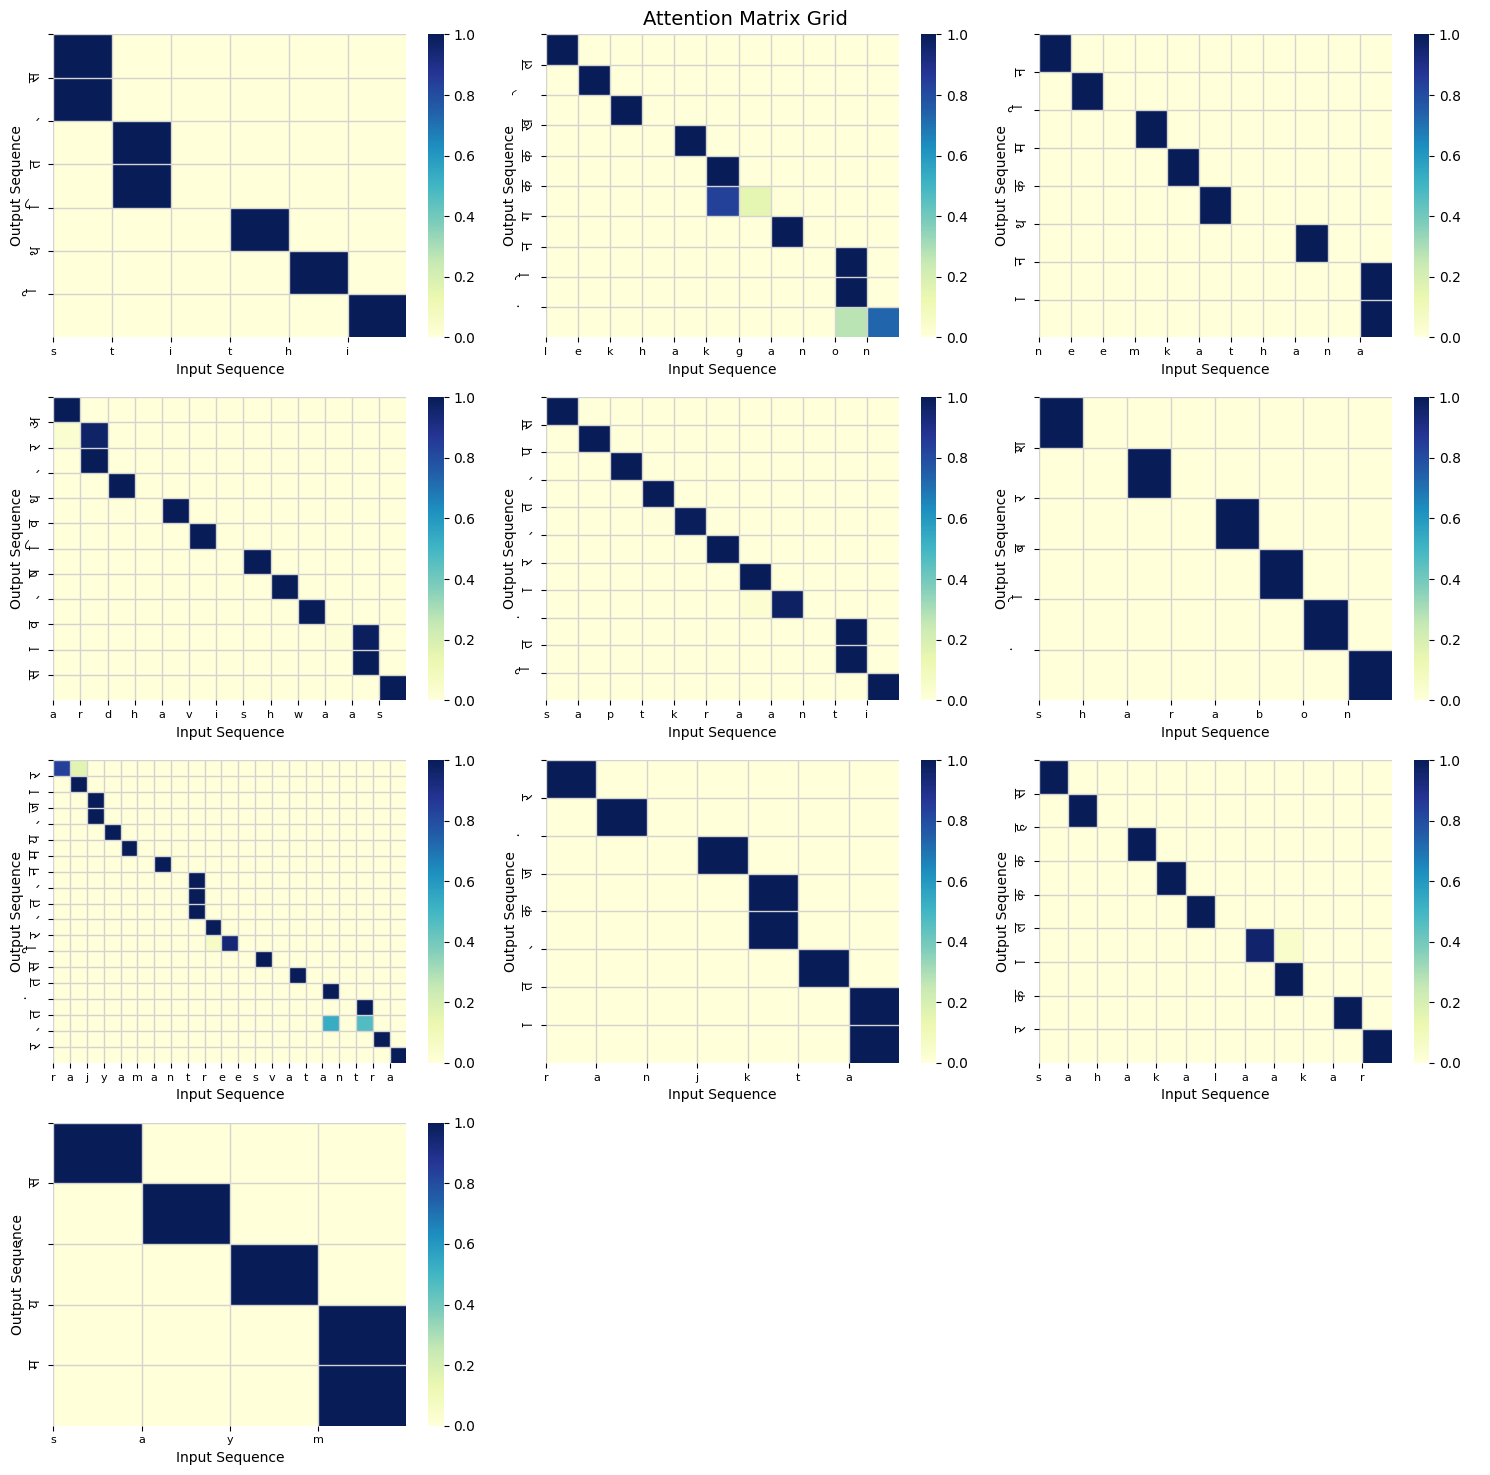

In [65]:
# Sample 10 random word-translation pairs from the test set for visualization
random_pairs = random.sample(list(zip(preprocessed_data['test_words'], preprocessed_data['test_translations'])), 10)

# Initialize empty lists to store inputs, outputs, and attention weights
inputs, outputs, attentions = [], [], []

# Iterate through each sampled word-translation pair
for i, (word_and_eos, translation_and_eos) in enumerate(random_pairs):
  # Extract the word sequence (excluding the end-of-sequence token)
  word = word_and_eos[:-1]

  # Extract the translated sequence (excluding the end-of-sequence token)
  translation = translation_and_eos[:-1]

  # Predict the translation and attention weights using the trained model
  output, attention = predict(trained_model, word, preprocessed_data, params)

  # Truncate the attention matrix to match the actual input word length
  attention = attention[1:, :, :(len(word))]

  # Append the input word sequence, predicted translation (with space prefix), and attention weights to their respective lists
  inputs.append(word)
  outputs.append(' ' + output)  # Add space before predicted translation for better readability
  attentions.append(attention)

# Plot the attention grid for the sampled word-translation pairs
plot_attention_grid(inputs, outputs, attentions, w_log = 0)


# TUNING HYPERPARAMETERS

In [ ]:
sweep_config = {
            'name': 'sweep 1.1 : random',
            'method': 'random',
            'metric': { 'goal': 'maximize','name': 'Accuracy'},
            'parameters': 
                {
                    'num_epochs': {'values': [10]},
                    'cell_type': {'values': ['RNN', 'LSTM', 'GRU']},
                    'embedding_size': {'values': [128, 256, 512]},
                    'hidden_size': {'values': [128, 256, 512]},
                    'num_layers': {'values': [1, 2, 3]},
                    'dropout': {'values': [0.3, 0.5, 0.7]},
                    'optimizer' : {'values' : ['adam', 'rmsprop', 'adagrad']},
                    'learning_rate': {'values': [0.001, 0.005, 0.01, 0.1]},
                    'batch_size': {'values': [32, 64]},
                    'teacher_fr' : {'values': [0.3, 0.5, 0.7]},
                    'length_penalty' : {'values': [0.4, 0.5, 0.6]},
                    'bi_dir' : {'values': [True, False]},
                    'beam_width': {'values': [1, 2, 3, 4, 5]}
                }
            }

In [ ]:
# sweep function
def run_sweep():
    init = wandb.init(project = 'DL-Assignment-3')
    config = init.config
    params = {
        'language' : 'hin',
        'dataset_path' : '/kaggle/input/dl-ass3/aksharantar_sampled',
        'num_epochs': config.num_epochs,
        'cell_type': config.cell_type,
        'embedding_size': config.embedding_size,
        'hidden_size': config.hidden_size,
        'num_layers_enc': config.num_layers,
        'num_layers_dec': config.num_layers,
        'dropout': config.dropout,
        'optimizer' : config.optimizer,
        'learning_rate': config.learning_rate,
        'batch_size': config.batch_size,
        'teacher_fr' : config.teacher_fr,
        'length_penalty' : config.length_penalty,
        'bi_dir' : config.bi_dir,
        'beam_width' : config.beam_width,
        'w_log' : 1
    }
    
    wandb.run.name = (
        'Q5_c:' + params['cell_type'] +
        '_e' + str(params['num_epochs']) +
        '_es:' + str(params['embedding_size']) +
        '_hs:' + str(params['hidden_size']) +
        '_nle:' + str(params['num_layers_enc']) +
        '_nld:' + str(params['num_layers_dec']) +
        '_o:' + params['optimizer'] +
        '_lr:' + str(params['learning_rate']) +
        '_bs:' + str(params['batch_size']) +
        '_tf:' + str(params['teacher_fr']) +
        '_lp:' + str(params['length_penalty']) +
        '_b:' + str(params['bi_dir']) +
        '_bw:' + str(params['beam_width'])
    )
    preprocessed_data = loadData(params)
    tensors = create_tensor(preprocessed_data)
    
    encoder = Encoder_Attention(params, preprocessed_data).to(device)
    decoder = Decoder_Attention(params, preprocessed_data).to(device)
    model = Seq2Seq_Attention(encoder, decoder, params, preprocessed_data).to(device) 
    
    criterion = nn.CrossEntropyLoss(ignore_index = 0)
    optimizer = get_optim(model,params)
    _, _, v_acc_beam = train(model, criterion, optimizer, preprocessed_data, tensors, params)
    wandb.log({'Accuracy': v_acc_beam})

In [ ]:
# # running sweeps
# sweep_id = wandb.sweep(sweep_config, project='DL-Assignment-3')
# wandb.agent(sweep_id, run_sweep, count = 25)
# wandb.finish()